# Inpainting with the deep decoder

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
#%matplotlib notebook

import os

import warnings
warnings.filterwarnings('ignore')

from include import *
from PIL import Image
import PIL

import numpy as np
import torch
import torch.optim
from Sophia import SophiaG
from Sophia import DecoupledSophia
from torch.autograd import Variable

import time



GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    print("num GPUs",torch.cuda.device_count())
else:
    dtype = torch.FloatTensor

num GPUs 1


## Load image

In [2]:
path = './test_data/'
img_name = "poster"

img_path = path + img_name + ".png"
img_pil = Image.open(img_path)
img_np = pil_to_np(img_pil)
img_clean_var = np_to_var(img_np).type(dtype)

output_depth = img_np.shape[0]
img_mask_pil = Image.open('./test_data/mask.png')
mask_np = pil_to_np(img_mask_pil)
mask_np = np.array([mask_np[0,:,:] / np.max(mask_np) ] * output_depth)
mask_var = np_to_var(mask_np).type(dtype)

## Generate inpainted image

In [3]:
img_noisy_var = img_clean_var * mask_var
img_noisy_np = var_to_np(img_noisy_var)

## Recover image

In [6]:
num_channels = [256]*5
net = decodernw(output_depth,num_channels_up=num_channels,upsample_first = True).type(dtype)

print("number of parameters: ", num_param(net))


rnd = 500
numit = 2000
rn = 0.005
sgd_time = time.time()
mse_n_sgd, mse_t_sgd, ni, net = fit( num_channels=num_channels,
                        reg_noise_std=rn,
                        reg_noise_decayevery = rnd,
                        num_iter=numit,
                        LR=0.05,
                        OPTIMIZER="SGD",
                        img_noisy_var=img_noisy_var,
                        net=net,
                        img_clean_var=img_clean_var,
                        mask_var = mask_var,
                        find_best=True,
                        )
sgd_time = time.time()-sgd_time

number of parameters:  397056
shape:  [1, 256, 16, 16]
optimize with SGD 0.025


In [4]:
num_channels = [256]*5
net = decodernw(output_depth,num_channels_up=num_channels,upsample_first = True).type(dtype)

print("number of parameters: ", num_param(net))

rnd = 500
numit = 10000
rn = 0.005

adam_time = time.time()

mse_n_adam, mse_t_adam, ni_adam, net_adam = fit( num_channels=num_channels,
                        reg_noise_std=rn,
                        reg_noise_decayevery = rnd,
                        num_iter=numit,
                        LR=0.0025,
                        OPTIMIZER="adam",
                        img_noisy_var=img_noisy_var,
                        net=net,
                        img_clean_var=img_clean_var,
                        mask_var = mask_var,
                        find_best=True,
                        )

adam_time = time.time()-adam_time

number of parameters:  397312
shape:  [1, 256, 16, 16]
optimize with adam 0.0025


In [5]:
num_channels = [256]*5
net = decodernw(output_depth,num_channels_up=num_channels,upsample_first = True).type(dtype)

print("number of parameters: ", num_param(net))

rnd = 500
numit = 10000
rn = 0.005
sophia_time = time.time()
mse_n_sophiag, mse_t_sophiag, ni_sophiag, net_sophiag = fit( num_channels=num_channels,
                        reg_noise_std=rn,
                        reg_noise_decayevery = rnd,
                        num_iter=numit,
                        LR=0.001,
                        OPTIMIZER="SophiaG",
                        img_noisy_var=img_noisy_var,
                        net=net,
                        img_clean_var=img_clean_var,
                        mask_var = mask_var,
                        find_best=True,
                        )
sophia_time = time.time()-sophia_time

number of parameters:  397312
shape:  [1, 256, 16, 16]
optimize with SophiaG


In [17]:
num_channels = [256]*5
net = decodernw(output_depth,num_channels_up=num_channels,upsample_first = True).type(dtype)

print("number of parameters: ", num_param(net))

rnd = 500
numit = 1000
rn = 0.005
omd_time = time.time()
mse_n_omd, mse_t_omd, ni_omd, net_omd = fit( num_channels=num_channels,
                        reg_noise_std=rn,
                        reg_noise_decayevery = rnd,
                        num_iter=numit,
                        LR=0.001,
                        OPTIMIZER="OMD",
                        img_noisy_var=img_noisy_var,
                        net=net,
                        img_clean_var=img_clean_var,
                        mask_var = mask_var,
                        find_best=True,
                        )
omd_time = time.time()-omd_time

number of parameters:  397056
shape:  [1, 256, 16, 16]
optimize with Optimistic Mirror Descent


KeyboardInterrupt: 

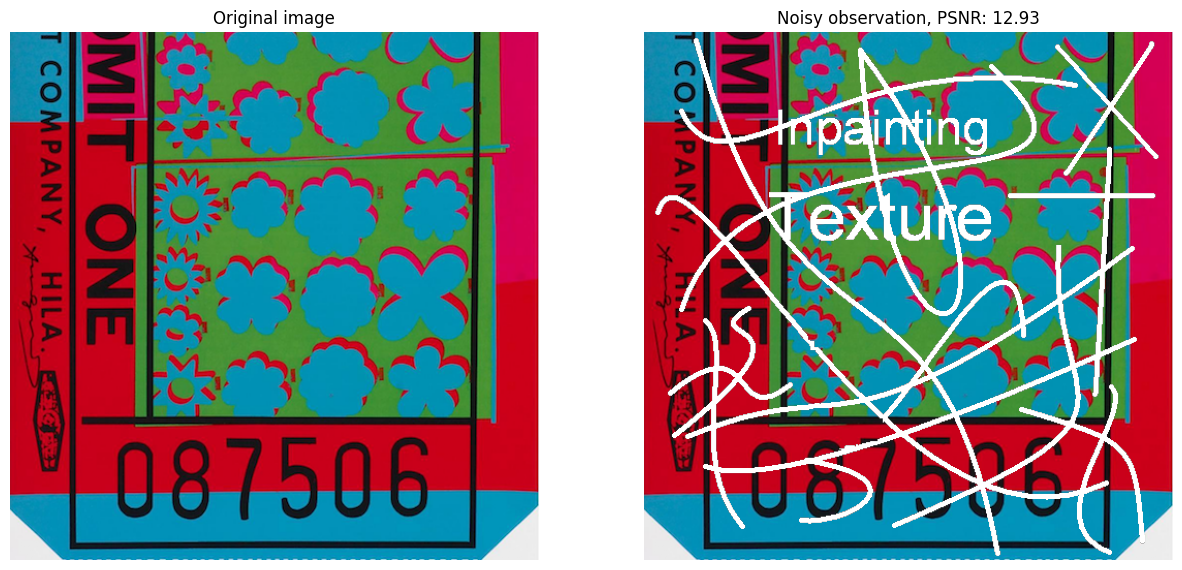

In [13]:
def myimgshow(plt,img):
    plt.imshow(np.clip(img.transpose(1, 2, 0),0,1))
    
fig = plt.figure(figsize = (15,15)) 
    
ax1 = fig.add_subplot(121)
myimgshow(ax1,img_np) 
ax1.set_title('Original image')
ax1.axis('off')
    
ax2 = fig.add_subplot(122)
myimgshow(ax2,img_noisy_np)
ax2.set_title( "Noisy observation, PSNR: %.2f" % psnr(img_np,img_noisy_np) )
ax2.axis('off')

plt.savefig('inpainting_setup.pdf')

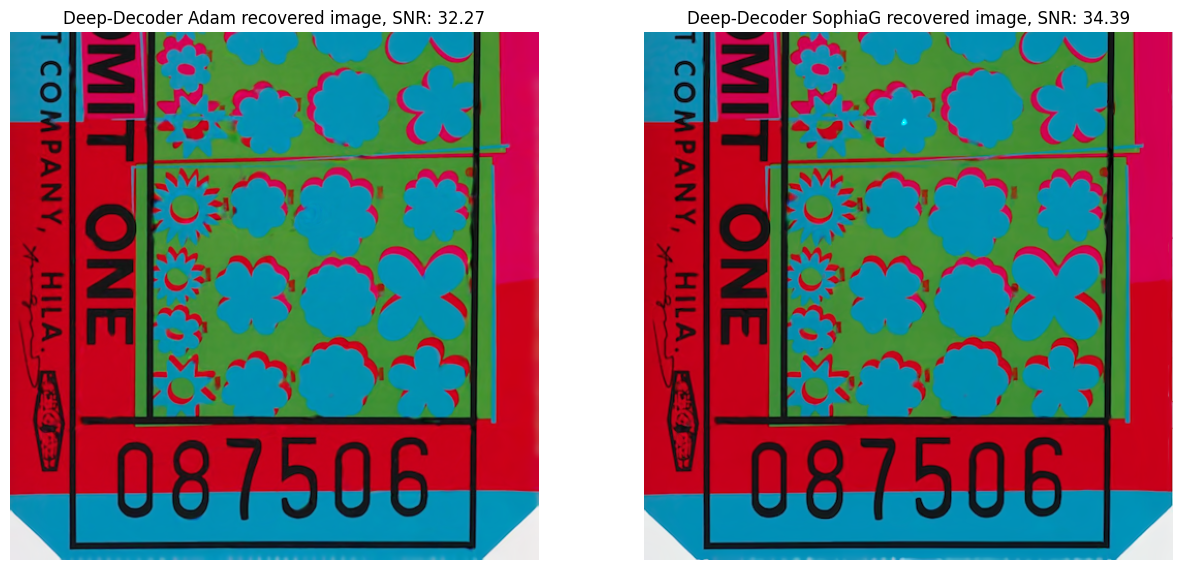

In [12]:
fig = plt.figure(figsize = (15,15)) 
out_img_np_adam = net_adam( ni_adam.type(dtype) ).data.cpu().numpy()[0]
ax1 = fig.add_subplot(121)
myimgshow(ax1,out_img_np_adam)
ax1.set_title( "Deep-Decoder Adam recovered image, SNR: %.2f" % psnr(img_np,out_img_np_adam) ) 
ax1.axis('off')  

out_img_np_sophiag = net_sophiag( ni_sophiag.type(dtype) ).data.cpu().numpy()[0]
ax2 = fig.add_subplot(122)
myimgshow(ax2,out_img_np_sophiag)
ax2.set_title( "Deep-Decoder SophiaG recovered image, SNR: %.2f" % psnr(img_np,out_img_np_sophiag) ) 
ax2.axis('off')  
#plt.show

plt.savefig('inpainting_result.pdf')

## Role of the choice of Optimizer

### Computational Cost

In [47]:
print('Pour ', numit, ' itérations:\n- Stochastic Gradient Descent : ',sgd_time,\
      ' secondes\n- Adam: ', adam_time, ' secondes\n- Sophia : ', \
     sophia_time, ' secondes\n- Optimistic Mirror Descent : ',omd_time, 'secondes')

Pour  10000  itérations:
- Stochastic Gradient Descent :  123.38307666778564  secondes
- Adam:  602.0812871456146  secondes
- Sophia :  606.770117521286  secondes
- Optimistic Mirror Descent :  117.81899785995483 secondes


### Convergence Analysis

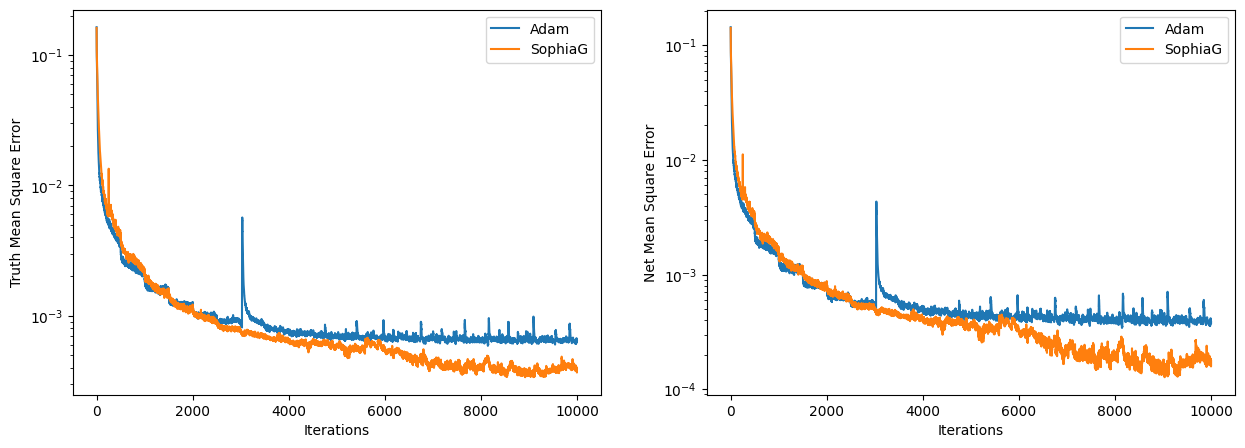

In [14]:
fig = plt.figure(figsize = (15,5)) 
#fig.settitle('Convergence Analysis')

ax1 = fig.add_subplot(121)
#ax1.semilogy(mse_t_sgd,label="SGD")
ax1.semilogy(mse_t_adam,label="Adam")
#ax1.semilogy(mse_t_lbfgs)
ax1.semilogy(mse_t_sophiag,label="SophiaG")
#ax1.semilogy(mse_t_sophiah,label="SophiaH")

#ax1.semilogy(mse_t_omd,label="OMD")
ax1.legend(['Adam','SophiaG'])
#ax1.legend(['SGD','Adam','Sophia','OMD'])

ax2 = fig.add_subplot(122)
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Truth Mean Square Error')
#ax2.semilogy(mse_n_sgd,label="SGD")
ax2.semilogy(mse_n_adam,label="Adam")
#ax2.semilogy(mse_n_lbfgs)
ax2.semilogy(mse_n_sophiag,label="SophiaG")
#ax2.semilogy(mse_n_sophiah,label="SophiaH")

#ax2.semilogy(mse_n_omd,label="OMD")
ax2.legend(['Adam','SophiaG'])
#ax2.legend(['SGD','Adam','Sophia','OMD'])

ax2.set_xlabel('Iterations')
ax2.set_ylabel('Net Mean Square Error')

plt.savefig('sophiag_vs_adam_rho0.01.pdf')

In [26]:
import tikzplotlib